```
sudo docker run --privileged --user carla --gpus all --net=host -e DISPLAY=$DISPLAY carlasim/carla-add:0.9.13 /bin/bash ./CarlaUE4.sh -world-port=12321 -RenderOffScreen
```

In [1]:
import carla

import time
import json
import random
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from env.CarlaEnv import CarlaEnv
from utils.VideoRecorder import VideoRecorder

In [3]:
with open('./cfg/weather.json', 'r', encoding='utf8') as fff:
    weather_params = json.load(fff)
with open('./cfg/scenario.json', 'r', encoding='utf8') as fff:
    scenario_params = json.load(fff)

max_fps = 20
min_fps = 20

In [4]:
selected_weather = "hard_high_light"
selected_scenario = "jaywalk"

In [5]:
carla_env = CarlaEnv(
    weather_params=weather_params,
    scenario_params=scenario_params,
    selected_weather=selected_weather,
    selected_scenario=selected_scenario,
    carla_rpc_port=12321,
    carla_tm_port=18935,
    carla_timeout=8,
    perception_type="dvs+vidar",
    # perception_type="rgb",
    num_cameras=5,
    rl_image_size=256,
    fov=60,
    max_fps=max_fps,
    min_fps=min_fps,
    max_episode_steps=1000,
    frame_skip=1,
    ego_auto_pilot=True,
    is_spectator=True,
)

carla env reset done.


In [6]:
throttle = []
brake = []
velocity = []

In [7]:
video = VideoRecorder("./video", min_fps=min_fps, max_fps=max_fps)

In [8]:
def _control_all_walkers(time_step):

    walker_behavior_params = scenario_params[selected_scenario]["walker_behavior"]
    
    left = carla.WalkerControl(
        direction=carla.Vector3D(y=-1.),
        speed=np.random.uniform(walker_behavior_params["speed"][0], walker_behavior_params["speed"][1]))
    right = carla.WalkerControl(
        direction=carla.Vector3D(y=1.),
        speed=np.random.uniform(walker_behavior_params["speed"][0], walker_behavior_params["speed"][1]))

    forward = carla.WalkerControl(
        direction=carla.Vector3D(x=1.),
        speed=np.random.uniform(walker_behavior_params["speed"][0], walker_behavior_params["speed"][1]))
    backward = carla.WalkerControl(
        direction=carla.Vector3D(x=-1.),
        speed=np.random.uniform(walker_behavior_params["speed"][0], walker_behavior_params["speed"][1]))

    all_veh_locs = [
        [one_actor.get_transform().location.x, one_actor.get_transform().location.y] 
        for one_actor in carla_env.vehicle_actors
    ]
    all_veh_locs = np.array(all_veh_locs, dtype=np.float32)
    
    for walker in carla_env.walker_actors:
        
        if walker.is_alive:
            # get location of the walker
            loc_x, loc_y = walker.get_location().x, walker.get_location().y
            vel_x, vel_y = walker.get_velocity().x, walker.get_velocity().y
            ego_loc = np.array([loc_x, loc_y], dtype=np.float32)
            
            # judge whether the walker can cross the road
            dis_gaps = np.linalg.norm(all_veh_locs - ego_loc, axis=1)
            is_cross = (dis_gaps >= walker_behavior_params["secure_dis"]).all()
            
            if loc_y > walker_behavior_params["border"]["y"][1]:
                if time_step % max_fps != 0 or random.random() > walker_behavior_params["cross_prob"]:
                    if loc_x > walker_behavior_params["border"]["x"][1]:
                        walker.apply_control(backward)

                    elif loc_x > walker_behavior_params["border"]["x"][0]:
                        if vel_x > 0:
                            walker.apply_control(forward)
                        else:
                            walker.apply_control(backward)

                    else:
                        walker.apply_control(forward)

                else:
                    walker.apply_control(left) if is_cross else None

            elif loc_y > walker_behavior_params["border"]["y"][0]:
                if vel_y > 0:
                    walker.apply_control(right) if is_cross else None
                else:
                    walker.apply_control(left) if is_cross else None

            elif time_step % max_fps != 0 or random.random() > walker_behavior_params["cross_prob"]:
                if loc_x > walker_behavior_params["border"]["x"][1]:
                    walker.apply_control(backward)

                elif loc_x > walker_behavior_params["border"]["x"][0]:
                    if vel_x > 0:
                        walker.apply_control(forward)
                    else:
                        walker.apply_control(backward)

                else:
                    walker.apply_control(forward)

            else:
                walker.apply_control(right) if is_cross else None

In [9]:
obs = carla_env.reset(seed=19961110)

print("starting init-frame:", carla_env.frame)

video.init(True) 
for one_step in range(10000):
    print(f"\t\r {one_step}", end="")
    carla_env.world.tick()
    
    _control_all_walkers(one_step)
#     obs, reward, done, info = carla_env.step(action=None)
    
#     throttle.append(carla_env.vehicle.get_control().throttle)
#     brake.append(carla_env.vehicle.get_control().brake)
#     velocity.append(carla_env.vehicle.get_velocity().x)
    
video.save("test") 

carla env reset done.
starting init-frame: 316
 9999																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																															

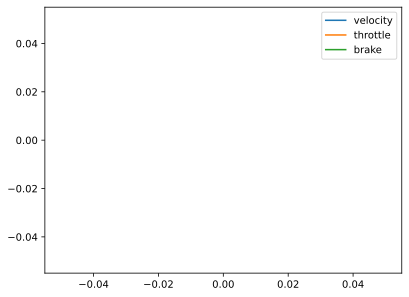

In [10]:
times = list(range(len(velocity)))

plt.plot(times, velocity, label="velocity")
plt.plot(times, throttle, label="throttle")
plt.plot(times, brake, label="brake")
plt.legend()